In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
from gradcam.utils.image import show_cam_on_image
from gradcam.multimae_cam import MultiMAECAM

from multimae.models.multimae import pretrain_multimae_base
from multimae.utils.plot_utils import plot_predictions
from multimae.models.criterion import MaskedCrossEntropyLoss, MaskedMSELoss, MaskedL1Loss
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch
from functools import partial
from multimae.models.input_adapters import PatchedInputAdapter, SemSegInputAdapter
from multimae.models.output_adapters import SpatialOutputAdapter
from multimae.utils.data_constants import CUSTOM_SEMSEG_NUM_CLASSES

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
device = torch.device('cuda')
prefix = "step_000358_"

In [3]:
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
sample_rgb = multimae_path / f"samples/{prefix}rgb.png"
sample_depth = multimae_path / f"samples/{prefix}depth.npy"
sample_semseg = multimae_path / f"samples/{prefix}semseg.png"
sample_label = multimae_path / f"samples/{prefix}label.npz"

(224, 224, 3)


(-0.5, 639.5, 479.5, -0.5)

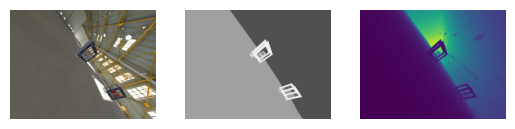

In [4]:
image = cv2.imread(str(sample_rgb))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
c, h, w = image_float.shape

image_float = TF.center_crop(image_float, min([h, w]))
image_float = TF.resize(image_float, 224)
image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
print(image_float.shape)

image = Image.fromarray(image)

semseg = cv2.imread(str(sample_semseg))
depth = np.load(str(sample_depth))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(semseg * 80)
axs[1].axis('off')

axs[2].imshow(depth)
axs[2].axis('off')

In [5]:
DOMAINS = ['rgb', 'depth', 'semseg']

DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3, stride_level=1),
    },
    'depth': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=1, stride_level=1),
    },
    'semseg': {
        'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                 dim_class_emb=64, interpolate_class_emb=False, stride_level=4),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=133, stride_level=4),
    },
}

input_adapters = {
    domain: dinfo['input_adapter'](patch_size_full=16)
    for domain, dinfo in DOMAIN_CONF.items()
}

output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full=16,
        dim_tokens=256,
        use_task_queries=True,
        depth=2,
        context_tasks=DOMAINS,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

model = pretrain_multimae_base(input_adapters=input_adapters, output_adapters=output_adapters)
CKPT_URL = 'https://github.com/EPFL-VILAB/MultiMAE/releases/download/pretrained-weights/multimae-b_98_rgb+-depth-semseg_1600e_multivit-afff3f8c.pth'
ckpt = torch.hub.load_state_dict_from_url(CKPT_URL, map_location='cpu')

### load checkpoints

In [6]:
model.load_state_dict(ckpt['model'], strict=False)
model.to("cuda")
model.eval()

MultiMAE(
  (input_adapters): ModuleDict(
    (rgb): PatchedInputAdapter(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (depth): PatchedInputAdapter(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (semseg): SemSegInputAdapter(
      (class_emb): Embedding(133, 64)
      (proj): Conv2d(64, 768, kernel_size=(4, 4), stride=(4, 4))
    )
  )
  (output_adapters): ModuleDict(
    (rgb): SpatialOutputAdapter(
      (task_embeddings): ParameterDict(
          (depth): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)]
          (rgb): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)]
          (semseg): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)]
      )
      (decoder): CrossAttention(
        (q): Linear(in_features=256, out_features=256, bias=True)
        (kv): Linear(in_features=256, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=Fals

In [7]:
# Pre-process RGB, depth and semseg to the MultiMAE input format
input_dict = {
    "rgb": np.expand_dims(image, [0, -1]),
    "depth": np.expand_dims(depth, [0, -1]),
    "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

processed_inputs = preprocess_multimae_inputs_in_batch(input_dict, batch_axis=True)
    
# To GPU
processed_inputs = {k: v.squeeze(-1).to("cuda") for k,v in processed_inputs.items()}

print(processed_inputs["rgb"].shape)
print(processed_inputs["depth"].shape)
print(processed_inputs["semseg"].shape)

inputs = {k: processed_inputs[k] for k in DOMAINS}

(1, 480, 640, 3, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 1, 1)
torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 56, 56])


In [8]:
seed = 1
torch.manual_seed(seed) # change seed to resample new mask
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

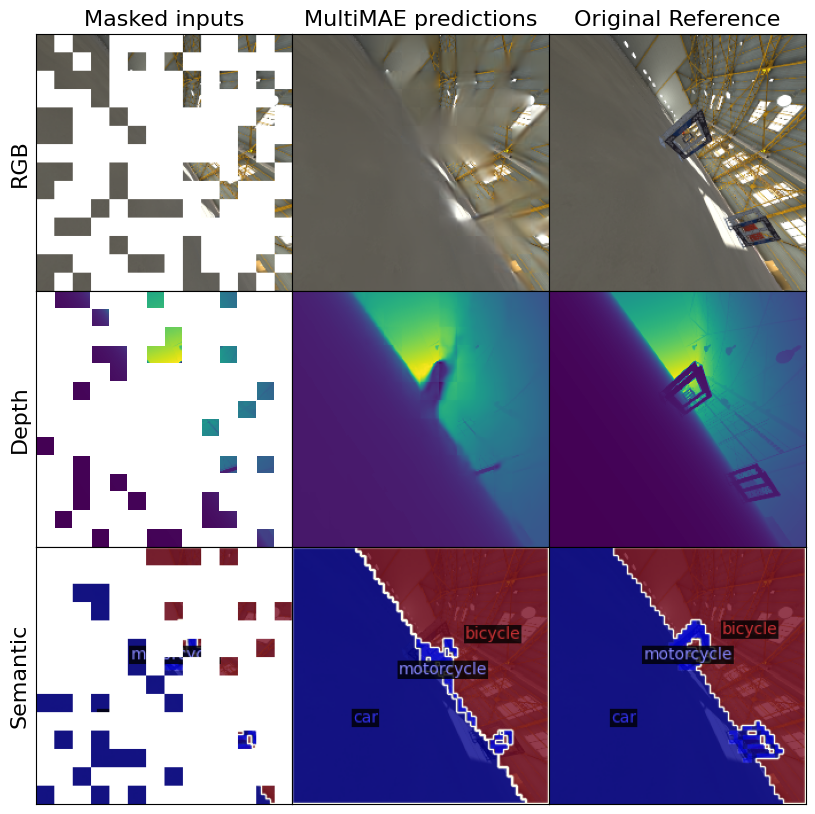

In [12]:
preds, masks = model(
    inputs, 
    num_encoded_tokens=128,
    alphas=1.0,
    mask_type="gate-oriented"
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(inputs, preds, masks)

In [8]:
target_layers = [model.encoder[-1].norm1]
cam = MultiMAECAM(model=model, target_layers=target_layers, use_cuda=True)

In [9]:
def plot_vis(res, image_float, grayscale_cam):
    fig = plt.figure(figsize=(10, 10))
    axs = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0)

    axs[0].imshow(res["rgb_input"])
    axs[0].axis('off')
    axs[0].set_title("RGB")

    axs[1].imshow(res["depth_input"])
    axs[1].axis('off')
    axs[1].set_title("Depth")

    axs[2].imshow(res["semseg_input"])
    axs[2].axis('off')
    axs[2].set_title("Semseg")

    cam_rgb = show_cam_on_image(image_float, grayscale_cam[0, :, :], use_rgb=True)
    axs[3].imshow(cam_rgb)
    axs[3].axis('off')

    axs[4].imshow(cam_rgb)
    axs[4].axis('off')

    axs[5].imshow(cam_rgb)
    axs[5].axis('off')

tensor([196], device='cuda:0')


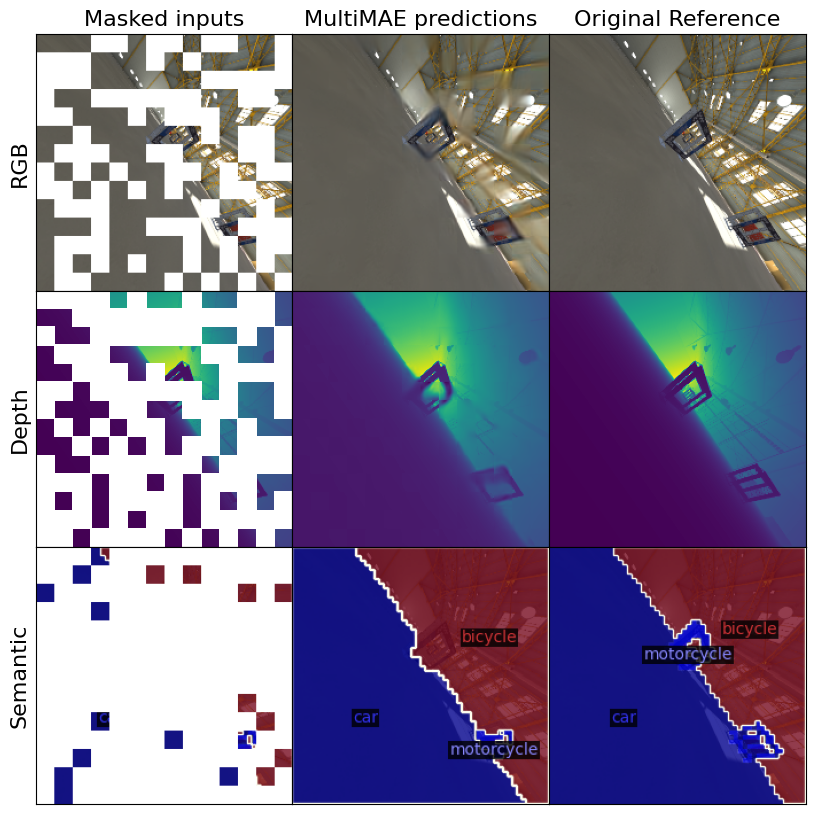

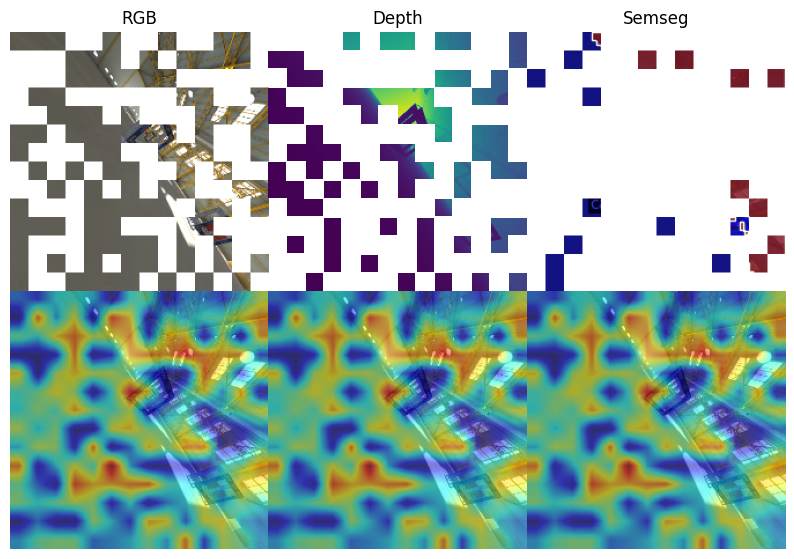

In [10]:
targets = {
    "rgb": MaskedMSELoss(),
    "depth": MaskedL1Loss(),
    "semseg": MaskedCrossEntropyLoss(stride=4)
}
preds, task_masks, grayscale_cam = cam(input_tensor=inputs, targets=targets, num_encoded_tokens=196, mask_type="non-overlap")
preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

res = plot_predictions(inputs, preds, masks, show_img=True)
plot_vis(res, image_float, grayscale_cam)

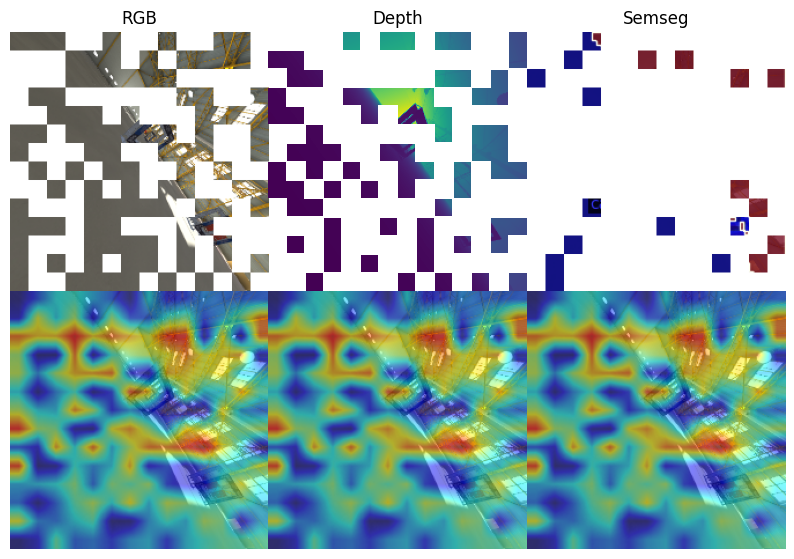

In [11]:
targets = {
    "rgb": MaskedMSELoss()
}
preds, task_masks, grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

res = plot_predictions(processed_inputs, preds, masks, show_img=False)
plot_vis(res, image_float, grayscale_cam)

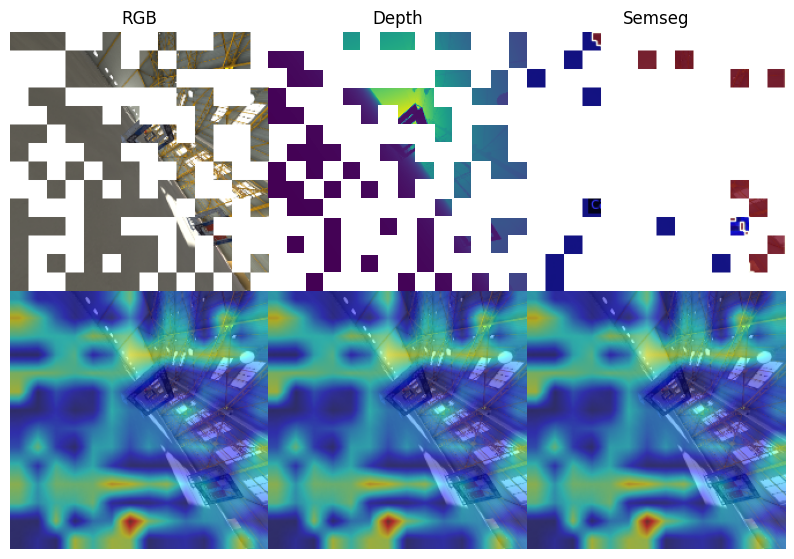

In [12]:
targets = {
    "depth": MaskedL1Loss(),
}
preds, task_masks, grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

res = plot_predictions(processed_inputs, preds, masks, show_img=False)
plot_vis(res, image_float, grayscale_cam)

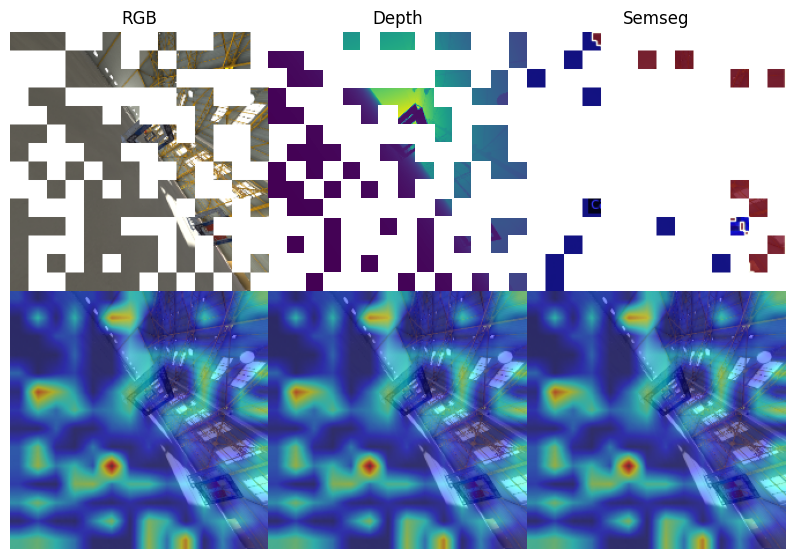

In [13]:
targets = {
    "semseg": MaskedCrossEntropyLoss(stride=4)
}
preds, task_masks, grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

res = plot_predictions(processed_inputs, preds, masks, show_img=False)
plot_vis(res, image_float, grayscale_cam)